# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 83.7 MB/s eta 0:00:00


In [2]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.base import clone
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import joblib 
import optuna
import os
import gc

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/ai-competition-africa/train.csv'
    test_path = '/kaggle/input/ai-competition-africa/test.csv'
    sample_sub_path = '/kaggle/input/ai-competition-africa/sample_submission.csv'
    
    target = 'quality'
    n_folds = 10
    seed = 1807

# Loading and processing the dataset

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')

X_mi = train.drop(CFG.target, axis=1)
y_mi = train[CFG.target]

mutual_info = mutual_info_classif(X_mi, y_mi, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_mi.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
alcohol,0.132434
total sulfur dioxide,0.017037
density,0.011314
fixed acidity,0.008313
volatile acidity,0.005341
residual sugar,0.005338
free sulfur dioxide,0.004799
pH,0.002568
sulphates,0.002522
citric acid,0.001762


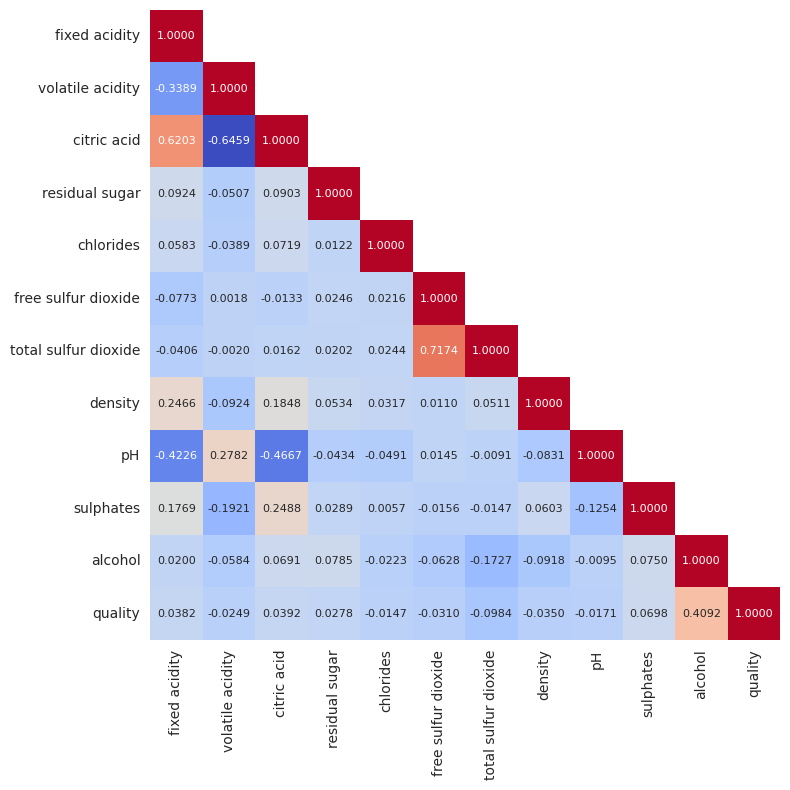

In [5]:
sns.set_style("white")
plt.figure(figsize=(8, 8))

corr_train = pd.concat([X_mi, y_mi], axis=1).corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.4f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 8},
    cbar=False
)

plt.tight_layout()
plt.show()

In [6]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

train[CFG.target] = train[CFG.target].astype(int) - 3

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

In [7]:
classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict

{0: 33.333333333333336,
 1: 5.506607929515418,
 2: 0.3880180040353872,
 3: 0.42265426880811496,
 4: 1.3144058885383807,
 5: 11.848341232227488}

# Training base models

In [8]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = cohen_kappa_score(y_val, np.argmax(y_pred_probs, axis=1), weights='quadratic')
            scores.append(score)
            
            print(f'--- Fold {fold_idx + 1} - QWK: {score:.6f}')
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        overall_score = cohen_kappa_score(y, np.argmax(oof_pred_probs, axis=1), weights='quadratic')
            
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
        
        os.makedirs('oof_pred_probs', exist_ok=True)
        os.makedirs('test_pred_probs', exist_ok=True)
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        return oof_pred_probs, test_pred_probs, scores      
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        joblib.dump(pred_probs, f'{name}_pred_probs/{model_name}_{name}_pred_probs_{cv_score:.6f}.pkl')

In [9]:
def save_submission(name, test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = np.argmax(test_pred_probs, axis=1)
    sub[CFG.target] = sub[CFG.target] + 3
    sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)
    return sub

In [10]:
xgb_params = {
    'colsample_bylevel': 0.6404275333807615,
    'colsample_bynode': 0.677216379685655,
    'colsample_bytree': 0.055016520513467504,
    'gamma': 1.3397427662455252,
    'learning_rate': 0.29198492361737705,
    'max_depth': 179,
    'max_leaves': 134,
    'min_child_weight': 49,
    'n_estimators': 1339,
    'n_jobs': -1,
    'random_state': 1807,
    'reg_alpha': 3.786913240917885,
    'reg_lambda': 1.2773576702808176,
    'subsample': 0.5643896571075894,
    'verbosity': 0
}

lgbm_params = {
    'boosting_type': "gbdt",
    'colsample_bytree': 0.5102238248629882,
    'learning_rate': 0.00802540678001897,
    'min_child_samples': 12,
    'min_child_weight': 0.1657027244453313,
    'n_estimators': 919,
    'n_jobs': -1,
    'num_leaves': 246,
    'random_state': 1807,
    'reg_alpha': 1.1379245074639632,
    'reg_lambda': 2.051906836441203,
    'subsample': 0.3931147578821031,
    'verbose': -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.6132230839614504,
    "learning_rate": 0.006384529863463788,
    "min_child_samples": 9,
    "min_child_weight": 0.041144996980290505,
    "n_estimators": 433,
    "n_jobs": -1,
    "num_leaves": 204,
    "random_state": 1807,
    "reg_alpha": 0.005360850081933544,
    "reg_lambda": 6.5671375036236235,
    "subsample": 0.6961054916271693,
    "verbose": -1
}

cb_params = {
    'border_count': 255,
    'colsample_bylevel': 0.5931157448549553,
    'depth': 10,
    'iterations': 773,
    'l2_leaf_reg': 3.765420998276193,
    'learning_rate': 0.01597655124745084,
    'min_child_samples': 182,
    'random_state': 1807,
    'random_strength': 0.8825883753353116,
    'verbose': False
}

hgb_params = {
    'l2_regularization': 0.5663413025070341,
    'learning_rate': 0.034684302286440864,
    'max_depth': 428,
    'max_features': 0.31593374020355874,
    'max_iter': 2231,
    'max_leaf_nodes': 316,
    'min_samples_leaf': 6,
    'random_state': 1807
}

gb_params = {
    'learning_rate': 0.022892261184251996,
    'max_depth': 4,
    'max_features': 0.8651402040271018,
    'max_leaf_nodes': 14,
    'min_samples_leaf': 0.04151937893954871,
    'min_samples_split': 0.4648429704666413,
    'min_weight_fraction_leaf': 0.034757204734238295,
    'n_estimators': 668,
    'random_state': 1807,
    'subsample': 0.8493090416178061
}

rf_params = {
    'min_samples_leaf': 6,
    'min_samples_split': 4,
    'n_estimators': 557,
    'n_jobs': -1,
    'random_state': 1807
}

adb_params = {
    'learning_rate': 1.052133653558254,
    'n_estimators': 111,
    'random_state': 1807
}

et_params = {
    'criterion': "gini",
    'min_samples_leaf': 2,
    'min_samples_split': 9,
    'n_estimators': 770,
    'n_jobs': -1,
    'random_state': 1807
}

In [11]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

## XGBoost

In [12]:
xgb_model = XGBClassifier(**xgb_params, class_weight=class_weight_dict)
xgb_trainer = Trainer(xgb_model)
oof_pred_probs['XGBoost'], test_pred_probs['XGBoost'], scores['XGBoost'] = xgb_trainer.fit_predict(X, y, X_test)

Training XGBClassifier

--- Fold 1 - QWK: 0.364721
--- Fold 2 - QWK: 0.362325
--- Fold 3 - QWK: 0.346530
--- Fold 4 - QWK: 0.388429
--- Fold 5 - QWK: 0.427116
--- Fold 6 - QWK: 0.396649
--- Fold 7 - QWK: 0.409746
--- Fold 8 - QWK: 0.398162
--- Fold 9 - QWK: 0.400376
--- Fold 10 - QWK: 0.390004

------ Overall: 0.388569 | Average: 0.388406 ± 0.022929


## LightGBM

In [13]:
lgbm_model = LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)
lgbm_trainer = Trainer(lgbm_model)
oof_pred_probs['LightGBM'], test_pred_probs['LightGBM'], scores['LightGBM'] = lgbm_trainer.fit_predict(X, y, X_test)

Training LGBMClassifier

--- Fold 1 - QWK: 0.385669
--- Fold 2 - QWK: 0.378666
--- Fold 3 - QWK: 0.343794
--- Fold 4 - QWK: 0.398201
--- Fold 5 - QWK: 0.400174
--- Fold 6 - QWK: 0.374101
--- Fold 7 - QWK: 0.417071
--- Fold 8 - QWK: 0.386978
--- Fold 9 - QWK: 0.379730
--- Fold 10 - QWK: 0.380110

------ Overall: 0.384357 | Average: 0.384450 ± 0.018284


## LightGBM (goss)

In [14]:
lgbm_goss_model = LGBMClassifier(**lgbm_goss_params, class_weight=class_weight_dict)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_pred_probs['LightGBM (goss)'], test_pred_probs['LightGBM (goss)'], scores['LightGBM (goss)'] = lgbm_goss_trainer.fit_predict(X, y, X_test)

Training LGBMClassifier

--- Fold 1 - QWK: 0.349772
--- Fold 2 - QWK: 0.362465
--- Fold 3 - QWK: 0.357601
--- Fold 4 - QWK: 0.412591
--- Fold 5 - QWK: 0.397740
--- Fold 6 - QWK: 0.375111
--- Fold 7 - QWK: 0.407469
--- Fold 8 - QWK: 0.399570
--- Fold 9 - QWK: 0.412394
--- Fold 10 - QWK: 0.386717

------ Overall: 0.386135 | Average: 0.386143 ± 0.022312


## CatBoost

In [15]:
cb_model = CatBoostClassifier(**cb_params, class_weights=class_weight_dict)
cb_trainer = Trainer(cb_model)
oof_pred_probs['CatBoost'], test_pred_probs['CatBoost'], scores['CatBoost'] = cb_trainer.fit_predict(X, y, X_test)

Training CatBoostClassifier

--- Fold 1 - QWK: 0.379128
--- Fold 2 - QWK: 0.376237
--- Fold 3 - QWK: 0.384222
--- Fold 4 - QWK: 0.416257
--- Fold 5 - QWK: 0.417416
--- Fold 6 - QWK: 0.401271
--- Fold 7 - QWK: 0.421149
--- Fold 8 - QWK: 0.409303
--- Fold 9 - QWK: 0.420524
--- Fold 10 - QWK: 0.396556

------ Overall: 0.402113 | Average: 0.402206 ± 0.016543


## HistGradientBoosting

In [16]:
hgb_model = HistGradientBoostingClassifier(**hgb_params, class_weight=class_weight_dict)
hgb_trainer = Trainer(hgb_model)
oof_pred_probs['HistGradientBoosting'], test_pred_probs['HistGradientBoosting'], scores['HistGradientBoosting'] = hgb_trainer.fit_predict(X, y, X_test)

Training HistGradientBoostingClassifier

--- Fold 1 - QWK: 0.368153
--- Fold 2 - QWK: 0.353484
--- Fold 3 - QWK: 0.360578
--- Fold 4 - QWK: 0.417574
--- Fold 5 - QWK: 0.405341
--- Fold 6 - QWK: 0.374362
--- Fold 7 - QWK: 0.393272
--- Fold 8 - QWK: 0.395135
--- Fold 9 - QWK: 0.380641
--- Fold 10 - QWK: 0.388336

------ Overall: 0.383645 | Average: 0.383688 ± 0.019093


## GradientBoosting

In [17]:
gb_model = GradientBoostingClassifier(**gb_params)
gb_trainer = Trainer(gb_model)
oof_pred_probs['GradientBoosting'], test_pred_probs['GradientBoosting'], scores['GradientBoosting'] = gb_trainer.fit_predict(X, y, X_test)

Training GradientBoostingClassifier

--- Fold 1 - QWK: 0.365666
--- Fold 2 - QWK: 0.375352
--- Fold 3 - QWK: 0.362483
--- Fold 4 - QWK: 0.393044
--- Fold 5 - QWK: 0.411334
--- Fold 6 - QWK: 0.394140
--- Fold 7 - QWK: 0.416760
--- Fold 8 - QWK: 0.412524
--- Fold 9 - QWK: 0.411021
--- Fold 10 - QWK: 0.400158

------ Overall: 0.394371 | Average: 0.394248 ± 0.019062


## RandomForest

In [18]:
rf_model = RandomForestClassifier(**rf_params, class_weight=class_weight_dict)
rf_trainer = Trainer(rf_model)
oof_pred_probs['RandomForest'], test_pred_probs['RandomForest'], scores['RandomForest'] = rf_trainer.fit_predict(X, y, X_test)

Training RandomForestClassifier

--- Fold 1 - QWK: 0.412401
--- Fold 2 - QWK: 0.401898
--- Fold 3 - QWK: 0.401520
--- Fold 4 - QWK: 0.437083
--- Fold 5 - QWK: 0.444500
--- Fold 6 - QWK: 0.420171
--- Fold 7 - QWK: 0.455436
--- Fold 8 - QWK: 0.428326
--- Fold 9 - QWK: 0.426446
--- Fold 10 - QWK: 0.417563

------ Overall: 0.424493 | Average: 0.424534 ± 0.016691


## AdaBoost

In [19]:
adb_model = AdaBoostClassifier(**adb_params)
adb_trainer = Trainer(adb_model)
oof_pred_probs['AdaBoost'], test_pred_probs['AdaBoost'], scores['AdaBoost'] = adb_trainer.fit_predict(X, y, X_test)

Training AdaBoostClassifier

--- Fold 1 - QWK: 0.366801
--- Fold 2 - QWK: 0.361702
--- Fold 3 - QWK: 0.329657
--- Fold 4 - QWK: 0.384680
--- Fold 5 - QWK: 0.384524
--- Fold 6 - QWK: 0.366313
--- Fold 7 - QWK: 0.399546
--- Fold 8 - QWK: 0.368084
--- Fold 9 - QWK: 0.370415
--- Fold 10 - QWK: 0.380277

------ Overall: 0.370739 | Average: 0.371200 ± 0.017649


## ExtraTrees

In [20]:
et_model = ExtraTreesClassifier(**et_params, class_weight=class_weight_dict)
et_trainer = Trainer(et_model)
oof_pred_probs['ExtraTrees'], test_pred_probs['ExtraTrees'], scores['ExtraTrees'] = et_trainer.fit_predict(X, y, X_test)

Training ExtraTreesClassifier

--- Fold 1 - QWK: 0.398515
--- Fold 2 - QWK: 0.397148
--- Fold 3 - QWK: 0.383379
--- Fold 4 - QWK: 0.420518
--- Fold 5 - QWK: 0.443225
--- Fold 6 - QWK: 0.408021
--- Fold 7 - QWK: 0.447764
--- Fold 8 - QWK: 0.427825
--- Fold 9 - QWK: 0.426814
--- Fold 10 - QWK: 0.405424

------ Overall: 0.415844 | Average: 0.415863 ± 0.019819


# Ensembling

In [21]:
def objective(trial):
    n_models = len(oof_pred_probs)
    weights = [trial.suggest_float(f'w_{i}', 0, 1) for i in range(n_models)]
    weights = np.array(weights) / np.sum(weights)

    oof_pred_probs_ensemble = np.zeros_like(oof_pred_probs['CatBoost'])
    for model, weight in zip(oof_pred_probs.values(), weights):
        oof_pred_probs_ensemble += model * weight
        
    return cohen_kappa_score(y, np.argmax(oof_pred_probs_ensemble, axis=1), weights='quadratic')

In [22]:
sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, n_jobs=-1)

[I 2024-12-23 17:58:02,913] A new study created in memory with name: no-name-44acf07f-859c-4b22-9b2b-0ea0bd77d6c4
[I 2024-12-23 17:58:02,942] Trial 1 finished with value: 0.421162310128955 and parameters: {'w_0': 0.3723088530884604, 'w_1': 0.19822931889357054, 'w_2': 0.34022479469726585, 'w_3': 0.991415324965196, 'w_4': 0.38955822931383566, 'w_5': 0.7144238725736911, 'w_6': 0.01177197920911044, 'w_7': 0.809643220545007, 'w_8': 0.7371019916687797}. Best is trial 1 with value: 0.421162310128955.
[I 2024-12-23 17:58:02,944] Trial 0 finished with value: 0.42071729797646595 and parameters: {'w_0': 0.0684621487692848, 'w_1': 0.3726917720933728, 'w_2': 0.6927674149380351, 'w_3': 0.9938122283687024, 'w_4': 0.41250901019849184, 'w_5': 0.7635777887075431, 'w_6': 0.9354014411105158, 'w_7': 0.4932600840574055, 'w_8': 0.08612620711878327}. Best is trial 1 with value: 0.421162310128955.
[I 2024-12-23 17:58:02,951] Trial 3 finished with value: 0.42046929081684303 and parameters: {'w_0': 0.08484355187

In [23]:
best_weights = study.best_params
best_weights = [best_weights[f'w_{i}'] for i in range(len(best_weights))]
best_weights = np.array(best_weights) / np.sum(best_weights)

oof_pred_probs_ensemble = np.zeros_like(oof_pred_probs['CatBoost'])

for model, weight in zip(oof_pred_probs.values(), best_weights):
      oof_pred_probs_ensemble += model * weight
      
overall_score = cohen_kappa_score(y, np.argmax(oof_pred_probs_ensemble, axis=1), weights='quadratic')
print(f'Overall QWK: {overall_score:.6f}')

Overall QWK: 0.424522


In [24]:
test_pred_probs_ensemble = np.zeros_like(test_pred_probs['CatBoost'])

for model, weight in zip(test_pred_probs.values(), best_weights):
    test_pred_probs_ensemble += model * weight
    
sub = save_submission('ensemble', test_pred_probs_ensemble, overall_score)

# Results

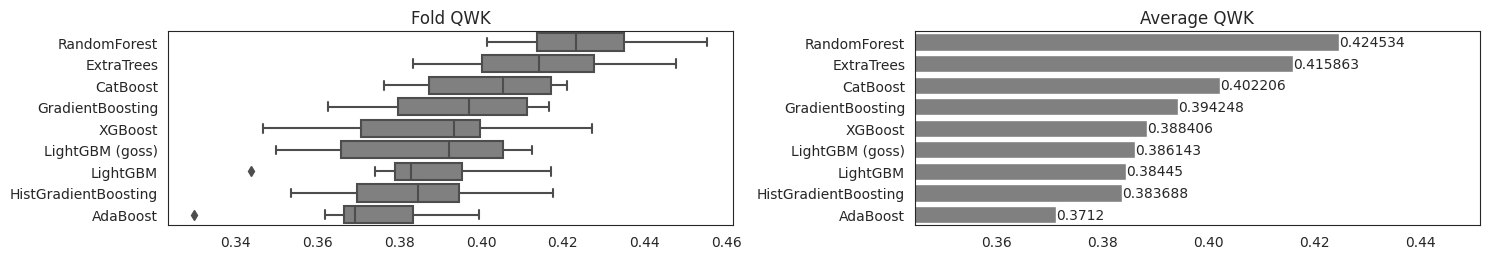

In [25]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', color='grey')
axs[0].set_title('Fold QWK')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color='grey')
axs[1].set_title('Average QWK')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = 'skyblue' if 'ensemble' in model.lower() else 'grey'
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

In [26]:
shutil.rmtree('catboost_info', ignore_errors=True)